# Assignment: Quantum Machine Learning

By: Sabah Ud Din Ahmad


---


If you are running this notebook in VS code, the environment must have the following libraries installed. 

`qiskit, qiskit-aer, qiskit-ibm-runtime, matplotlib, pylatexenc, pandas, scikit-learn`

## Question 1

For the data generated in notebook QML3a, design a parametrized circuit by using a choice of your own encoding scheme. You should aim for a classification accuracy on the training and test data set of up to 90%.

Note: It was clarified on Discord that we must use the data in notebook QML3a and not QML3b (which is a typo on Canvas).

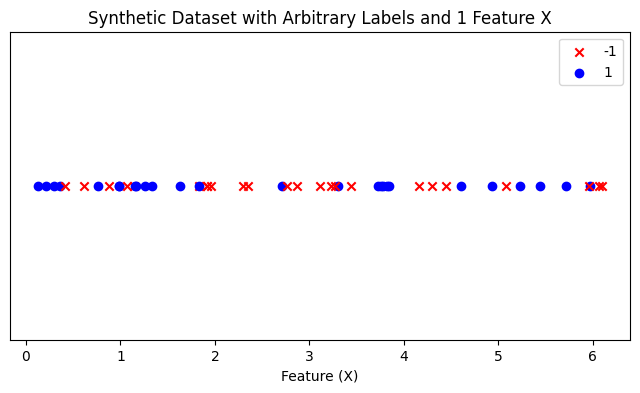

In [1]:
# Dataset: Assign arbitrary labels (-1 or 1) randomly to each sample
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
X = np.random.rand(50) * 2*np.pi  # 20 random samples in range [0, 10]
y_arbitrary = np.random.choice([-1, 1], size=X.shape)

# Plot with arbitrary labels
plt.figure(figsize=(8, 4))
for xi, yi in zip(X, y_arbitrary):
    if yi == 1:
        plt.scatter(xi, 0, marker='o', color='blue', label='1' if '1' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.scatter(xi, 0, marker='x', color='red', label='-1' if '-1' not in plt.gca().get_legend_handles_labels()[1] else "")
plt.xlabel('Feature (X)')
plt.yticks([])
plt.legend()
plt.title('Synthetic Dataset with Arbitrary Labels and 1 Feature X')
plt.show()

In [2]:
#split the data into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_arbitrary, test_size=0.3, random_state=42)

In [3]:
# print the size of train and test data
test_size = np.shape(X_test)[0]
train_size = np.shape(X_train)[0]
print('test size:', test_size, ', train size:', train_size)

test size: 15 , train size: 35


### Solution 1 (Attempt 1)

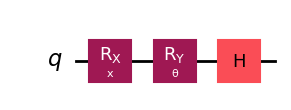

In [4]:
from qiskit.circuit import Parameter, QuantumCircuit

circuit = QuantumCircuit(1)
x = Parameter('x')
theta = Parameter('θ')
circuit.rx(x, 0)
circuit.ry(theta, 0)
circuit.h(0)

circuit.draw('mpl')

In [5]:
from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp.from_list([("Z", 1)])
observable

SparsePauliOp(['Z'],
              coeffs=[1.+0.j])

In [6]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
import numpy as np

def forward(circuit,input_params,weight_params,estimator,observable):
    num_samples = input_params.shape[0]
    weights0 = np.full_like(input_params, weight_params[0])
    params= [[inp, w0] for inp, w0 in zip(input_params, weights0)]
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
    return expectation_values

def mse_loss(predict, target):
    return ((predict - target) ** 2).mean()

def mse_loss_weights(weight_params):
    predictions = forward(circuit=circuit,input_params=input_params,
        weight_params=weight_params,estimator=estimator,observable=observable)

    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)

    global iter
    if iter % 10 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

In [7]:
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
import numpy as np
num_epochs = 1
num_samples = len(X_train)

# Globals
circuit = circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

weight_params = np.random.rand() * 2 * np.pi

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    input_params = X_train
    target = y_train
    iter = 0
    res = minimize(
        mse_loss_weights, weight_params, method = "COBYLA", options={"maxiter": 100,'tol': 1e-8}
    )
    weight_params = res["x"]

Epoch: 0
Iter: 0, loss: 1.9507547147112583
Iter: 10, loss: 0.9079222700049664
Iter: 20, loss: 0.9076830283144324
Iter: 30, loss: 0.9076828874842195
Iter: 40, loss: 0.9076828874058118


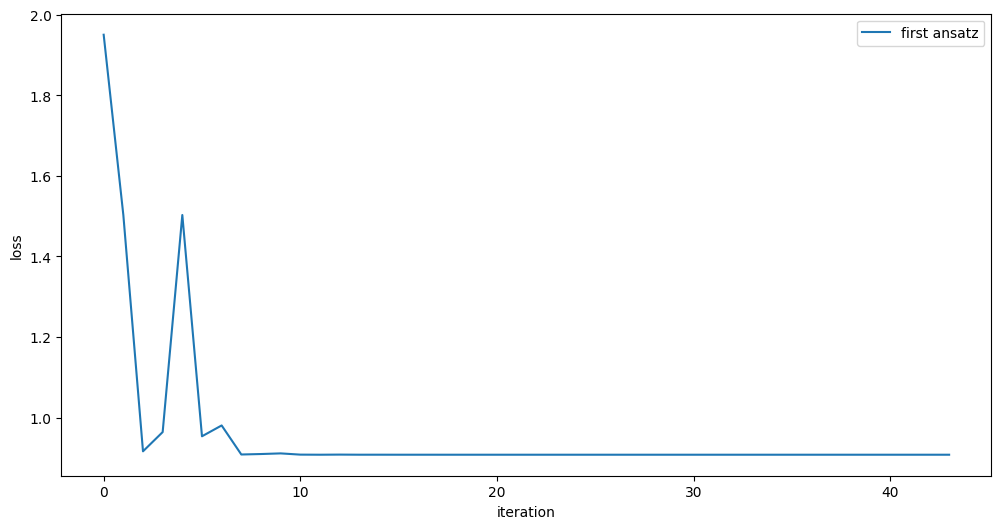

In [8]:
obj_func_vals_first = objective_func_vals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

In [9]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator

estimator = Estimator()

pred_train = forward(circuit, np.array(X_train), res["x"], estimator, observable)
print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(y_train)

accuracy = accuracy_score(y_train, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[ 0.39215718 -0.41961212 -0.15872785 -0.41647206  0.1705785  -0.10931771
 -0.14032164 -0.40391425  0.41005505  0.20102996 -0.29598789 -0.02314732
 -0.41812696  0.39833998  0.2337911   0.40205189  0.41232435 -0.14124487
  0.39983637  0.26862102 -0.04739354  0.35348923  0.15060224 -0.28030626
  0.30231927  0.41629855 -0.10987082 -0.3820068   0.16707688 -0.32032802
  0.27994144  0.41004343  0.17437697 -0.35099967 -0.16857934]
[ 1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1.  1.  1.  1. -1.
  1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1.]
[ 1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1  1  1 -1 -1
  1  1  1  1  1  1  1  1 -1  1 -1]
Train accuracy: 62.857142857142854%


In [10]:
pred_test = forward(circuit, np.array(X_test), res["x"], estimator, observable)
print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(y_test)

accuracy = accuracy_score(y_test, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[ 0.09841411 -0.39047259 -0.3275545  -0.21929732 -0.4147364  -0.40185412
  0.13054492  0.0920305   0.3852238  -0.10753834  0.20786453  0.23373826
  0.34320199 -0.33789223 -0.34169708]
[ 1. -1. -1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1.]
[ 1 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1  1  1]
Test accuracy: 60.0%


### Solution 1 (Attempt 2)

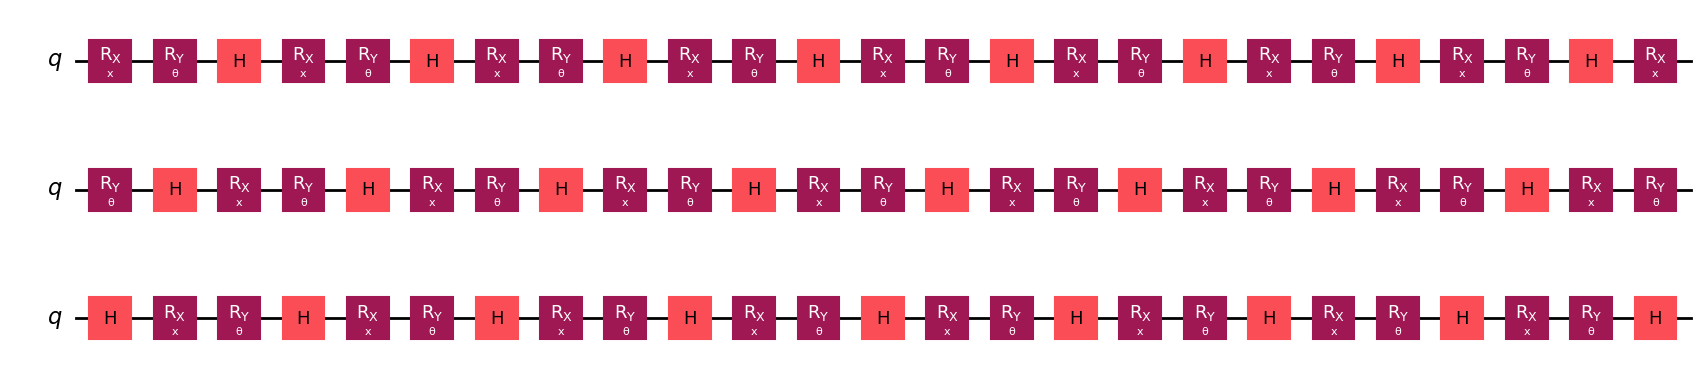

In [18]:
from qiskit.circuit import Parameter, QuantumCircuit

circuit = QuantumCircuit(1)
x = Parameter('x')
theta = Parameter('θ')
for i in range(25):
    circuit.rx(x, 0)
    circuit.ry(theta, 0)
    circuit.h(0)

circuit.draw('mpl')

In [19]:
from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp.from_list([("Z", 1)])
observable

SparsePauliOp(['Z'],
              coeffs=[1.+0.j])

In [20]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
import numpy as np

def forward(circuit,input_params,weight_params,estimator,observable):
    num_samples = input_params.shape[0]
    weights0 = np.full_like(input_params, weight_params[0])
    params= [[inp, w0] for inp, w0 in zip(input_params, weights0)]
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
    return expectation_values

def mse_loss(predict, target):
    return ((predict - target) ** 2).mean()

def mse_loss_weights(weight_params):
    predictions = forward(circuit=circuit,input_params=input_params,
        weight_params=weight_params,estimator=estimator,observable=observable)

    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)

    global iter
    if iter % 10 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

In [21]:
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
import numpy as np
num_epochs = 1
num_samples = len(X_train)

# Globals
circuit = circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

weight_params = np.random.rand() * 2 * np.pi

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    input_params = X_train
    target = y_train
    iter = 0
    res = minimize(
        mse_loss_weights, weight_params, method = "COBYLA", options={"maxiter": 100,'tol': 1e-8}
    )
    weight_params = res["x"]

Epoch: 0
Iter: 0, loss: 1.7176640166360801
Iter: 10, loss: 1.6945284545932882
Iter: 20, loss: 1.0594229663816712
Iter: 30, loss: 1.0592909777469453
Iter: 40, loss: 1.0592909369831014


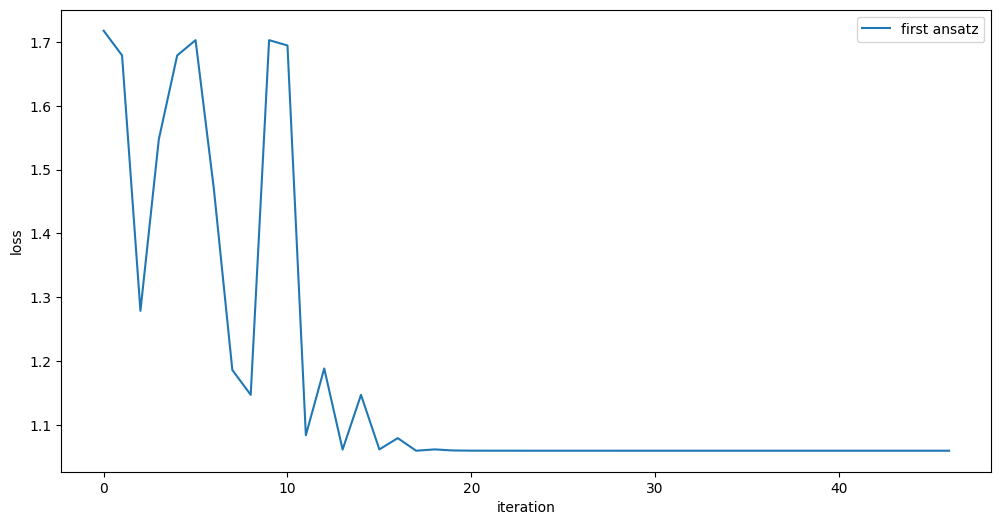

In [22]:
obj_func_vals_first = objective_func_vals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

In [23]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator

estimator = Estimator()

pred_train = forward(circuit, np.array(X_train), res["x"], estimator, observable)
print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(y_train)

accuracy = accuracy_score(y_train, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[ 0.48642265 -0.68437865 -0.43342096 -0.62898606  0.98935648  0.23093502
 -0.25627058 -0.38614532  0.99967753  0.85287725  0.95773187  0.93422023
 -0.65849118  0.69667564  0.37447069  0.83208104  0.96977606 -0.26775042
  0.7520771   0.18105641  0.9922964   0.72604     0.82910812  0.82312979
  0.66897865  0.7617048   0.2212714   0.07889402  0.97457801  0.97955645
  0.28609614  0.99970412  0.99826571  0.66941656 -0.47775258]
[ 1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.]
[ 1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1  1  1 -1 -1
  1  1  1  1  1  1  1  1 -1  1 -1]
Train accuracy: 71.42857142857143%


In [24]:
pred_test = forward(circuit, np.array(X_test), res["x"], estimator, observable)
print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(y_test)

accuracy = accuracy_score(y_test, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[ 6.30885740e-02 -1.02686820e-01  9.39009195e-01 -1.27991061e-01
 -5.97331391e-01 -3.43783792e-01  5.35485563e-01  1.00267878e-04
  3.35457852e-01  2.62051358e-01  7.65734927e-01  3.75211812e-01
  9.11674602e-01  8.44767724e-01  7.99932513e-01]
[ 1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 1 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1  1  1]
Test accuracy: 73.33333333333333%


### Solution 1 (Attempt 3)

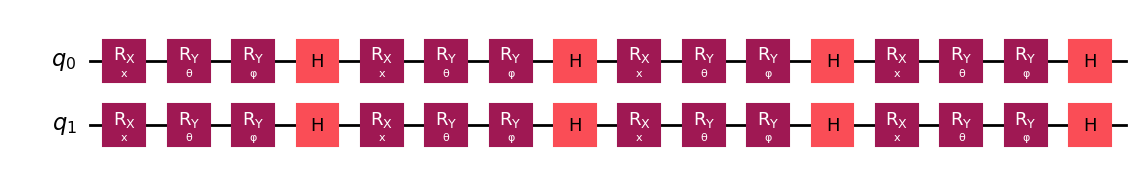

In [11]:
from qiskit.circuit import Parameter, QuantumCircuit

circuit = QuantumCircuit(2)
x = Parameter('x')
theta = Parameter('θ')
phi = Parameter('φ')
for i in range(4):
    circuit.rx(x, 0)
    circuit.ry(theta, 0)
    circuit.ry(phi, 0)
    circuit.rx(x, 1)
    circuit.ry(theta, 1)
    circuit.ry(phi, 1)
    circuit.h(0)
    circuit.h(1)

circuit.draw('mpl')

In [12]:
from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp.from_list([("ZZ", 1)])
observable

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])

In [13]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
import numpy as np

def forward(circuit,input_params,weight_params,estimator,observable):
    num_samples = input_params.shape[0]
    weights0 = np.full_like(input_params, weight_params[0])
    weights1 = np.full_like(input_params, weight_params[1])
    params= [[inp, w0, w1] for inp, w0, w1 in zip(input_params, weights0, weights1)]
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
    return expectation_values

def mse_loss(predict, target):
    return ((predict - target) ** 2).mean()

def mse_loss_weights(weight_params):
    predictions = forward(circuit=circuit,input_params=input_params,
        weight_params=weight_params,estimator=estimator,observable=observable)

    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)

    global iter
    if iter % 10 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

In [14]:
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
import numpy as np
num_epochs = 1
num_samples = len(X_train)

# Globals
circuit = circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

weight_params = np.random.rand(2) * 2 * np.pi

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    input_params = X_train
    target = y_train
    iter = 0
    res = minimize(
        mse_loss_weights, weight_params, method = "COBYLA", options={"maxiter": 100,'tol': 1e-8}
    )
    weight_params = res["x"]

Epoch: 0
Iter: 0, loss: 1.0709791144512182
Iter: 10, loss: 1.0718745608682738
Iter: 20, loss: 1.0569293697634747
Iter: 30, loss: 1.0569270405883842
Iter: 40, loss: 1.0569270400390172
Iter: 50, loss: 1.056927040025473


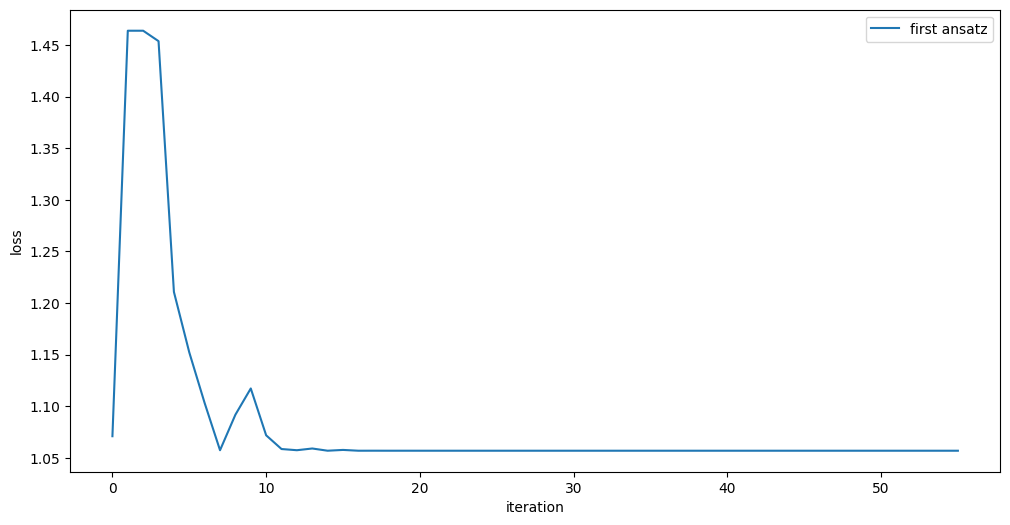

In [15]:
obj_func_vals_first = objective_func_vals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

In [16]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator

estimator = Estimator()

pred_train = forward(circuit, np.array(X_train), res["x"], estimator, observable)
print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(y_train)

accuracy = accuracy_score(y_train, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[7.90369393e-01 2.18190140e-02 5.46192527e-02 1.97775217e-02
 1.83591173e-02 5.96636560e-02 5.77394130e-02 1.27082545e-02
 9.22813369e-01 4.82332015e-02 8.59546389e-03 4.28597494e-02
 2.08395140e-02 8.34769739e-01 1.01231408e-01 8.62111104e-01
 9.40461416e-01 5.76165009e-02 8.45729985e-01 1.86086645e-01
 5.05225493e-02 5.44677340e-01 7.13136522e-03 1.35459520e-02
 3.00714081e-01 9.71832190e-01 5.96677805e-02 4.32576033e-03
 1.59531519e-02 2.76253956e-03 2.20810870e-01 9.22723497e-01
 2.11934211e-02 1.23343318e-05 5.24020956e-02]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1  1  1 -1 -1
  1  1  1  1  1  1  1  1 -1  1 -1]
Train accuracy: 48.57142857142857%


In [17]:
pred_test = forward(circuit, np.array(X_test), res["x"], estimator, observable)
print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(y_test)

accuracy = accuracy_score(y_test, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[1.06083685e-03 6.99657667e-03 1.59033542e-03 3.63543831e-02
 1.86968401e-02 1.17113971e-02 1.34132777e-03 2.04344068e-03
 7.42270926e-01 5.96407716e-02 5.73651837e-02 1.01126214e-01
 4.88416928e-01 4.47805865e-04 1.98968311e-04]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 1 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1  1  1]
Test accuracy: 60.0%


### Solution 1 (Attempt 4)

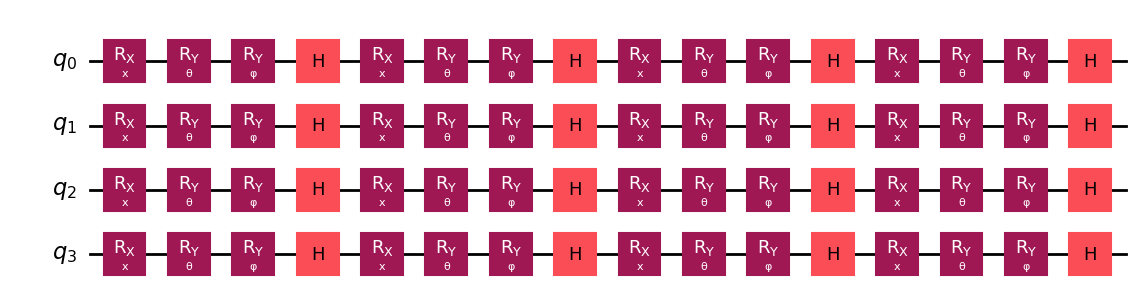

In [18]:
from qiskit.circuit import Parameter, QuantumCircuit

circuit = QuantumCircuit(4)
x = Parameter('x')
theta = Parameter('θ')
phi = Parameter('φ')
for i in range(4):
    circuit.rx(x, 0)
    circuit.ry(theta, 0)
    circuit.ry(phi, 0)
    circuit.rx(x, 1)
    circuit.ry(theta, 1)
    circuit.ry(phi, 1)
    circuit.rx(x, 2)
    circuit.ry(theta, 2)
    circuit.ry(phi, 2)
    circuit.rx(x, 3)
    circuit.ry(theta, 3)
    circuit.ry(phi, 3)
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.h(3)

circuit.draw('mpl')

In [19]:
from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp.from_list([("ZZZZ", 1)])
observable

SparsePauliOp(['ZZZZ'],
              coeffs=[1.+0.j])

In [20]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
import numpy as np

def forward(circuit,input_params,weight_params,estimator,observable):
    num_samples = input_params.shape[0]
    weights0 = np.full_like(input_params, weight_params[0])
    weights1 = np.full_like(input_params, weight_params[1])
    params= [[inp, w0, w1] for inp, w0, w1 in zip(input_params, weights0, weights1)]
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
    return expectation_values

def mse_loss(predict, target):
    return ((predict - target) ** 2).mean()

def mse_loss_weights(weight_params):
    predictions = forward(circuit=circuit,input_params=input_params,
        weight_params=weight_params,estimator=estimator,observable=observable)

    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)

    global iter
    if iter % 10 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

In [21]:
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
import numpy as np
num_epochs = 1
num_samples = len(X_train)

# Globals
circuit = circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

weight_params = np.random.rand(2) * 2 * np.pi

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    input_params = X_train
    target = y_train
    iter = 0
    res = minimize(
        mse_loss_weights, weight_params, method = "COBYLA", options={"maxiter": 100,'tol': 1e-8}
    )
    weight_params = res["x"]

Epoch: 0
Iter: 0, loss: 1.330300022378361
Iter: 10, loss: 1.1315830150048833
Iter: 20, loss: 1.120447616896407
Iter: 30, loss: 1.1204254038876733
Iter: 40, loss: 1.120425367456702
Iter: 50, loss: 1.1204253672175746
Iter: 60, loss: 1.1204253672175608


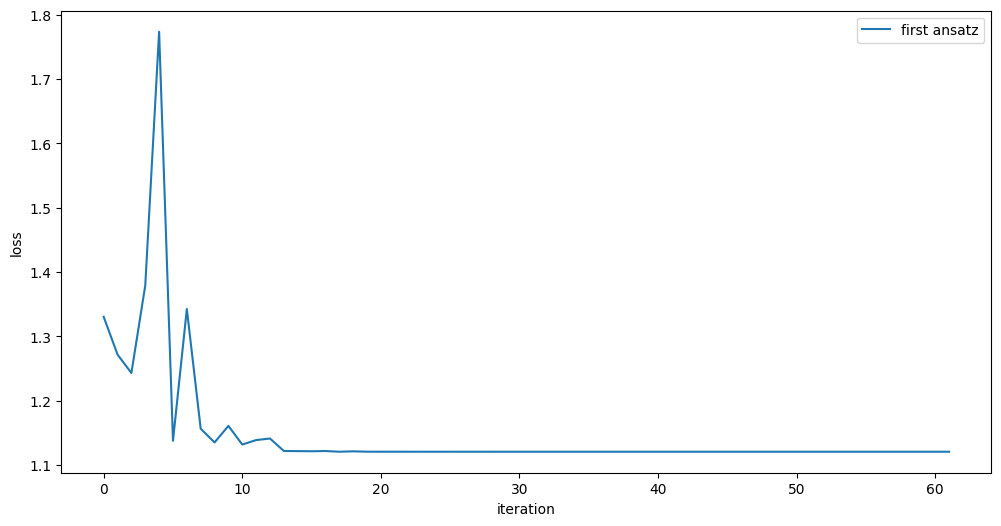

In [22]:
obj_func_vals_first = objective_func_vals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

In [23]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator

estimator = Estimator()

pred_train = forward(circuit, np.array(X_train), res["x"], estimator, observable)
print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(y_train)

accuracy = accuracy_score(y_train, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[9.74044572e-01 5.69157920e-02 1.58551798e-03 5.28201469e-02
 4.34996958e-01 9.54449564e-03 3.45218054e-03 3.86615651e-02
 9.92539159e-01 5.21064453e-01 4.46228266e-04 5.92757291e-02
 5.49492119e-02 9.81119708e-01 6.15477737e-01 9.85022620e-01
 9.94443718e-01 3.33251543e-03 9.82724497e-01 7.13770447e-01
 3.91207792e-02 9.14590909e-01 3.80773439e-01 1.16316387e-04
 8.02343601e-01 9.97534340e-01 9.39524053e-03 2.11308485e-02
 4.25334983e-01 1.97111270e-03 7.44468843e-01 9.92529147e-01
 4.45544186e-01 7.53982246e-03 9.65157906e-04]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1  1  1 -1 -1
  1  1  1  1  1  1  1  1 -1  1 -1]
Train accuracy: 48.57142857142857%


In [24]:
pred_test = forward(circuit, np.array(X_test), res["x"], estimator, observable)
print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(y_test)

accuracy = accuracy_score(y_test, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[2.52594333e-01 2.69557229e-02 2.81462798e-03 7.67019298e-06
 5.06562301e-02 3.66518767e-02 3.28906757e-01 2.38561997e-01
 9.65275059e-01 1.00360187e-02 5.40718671e-01 6.15325842e-01
 8.94756661e-01 4.47061171e-03 5.23795611e-03]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 1 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1  1  1]
Test accuracy: 60.0%


### Solution 1 (Attempt 5)

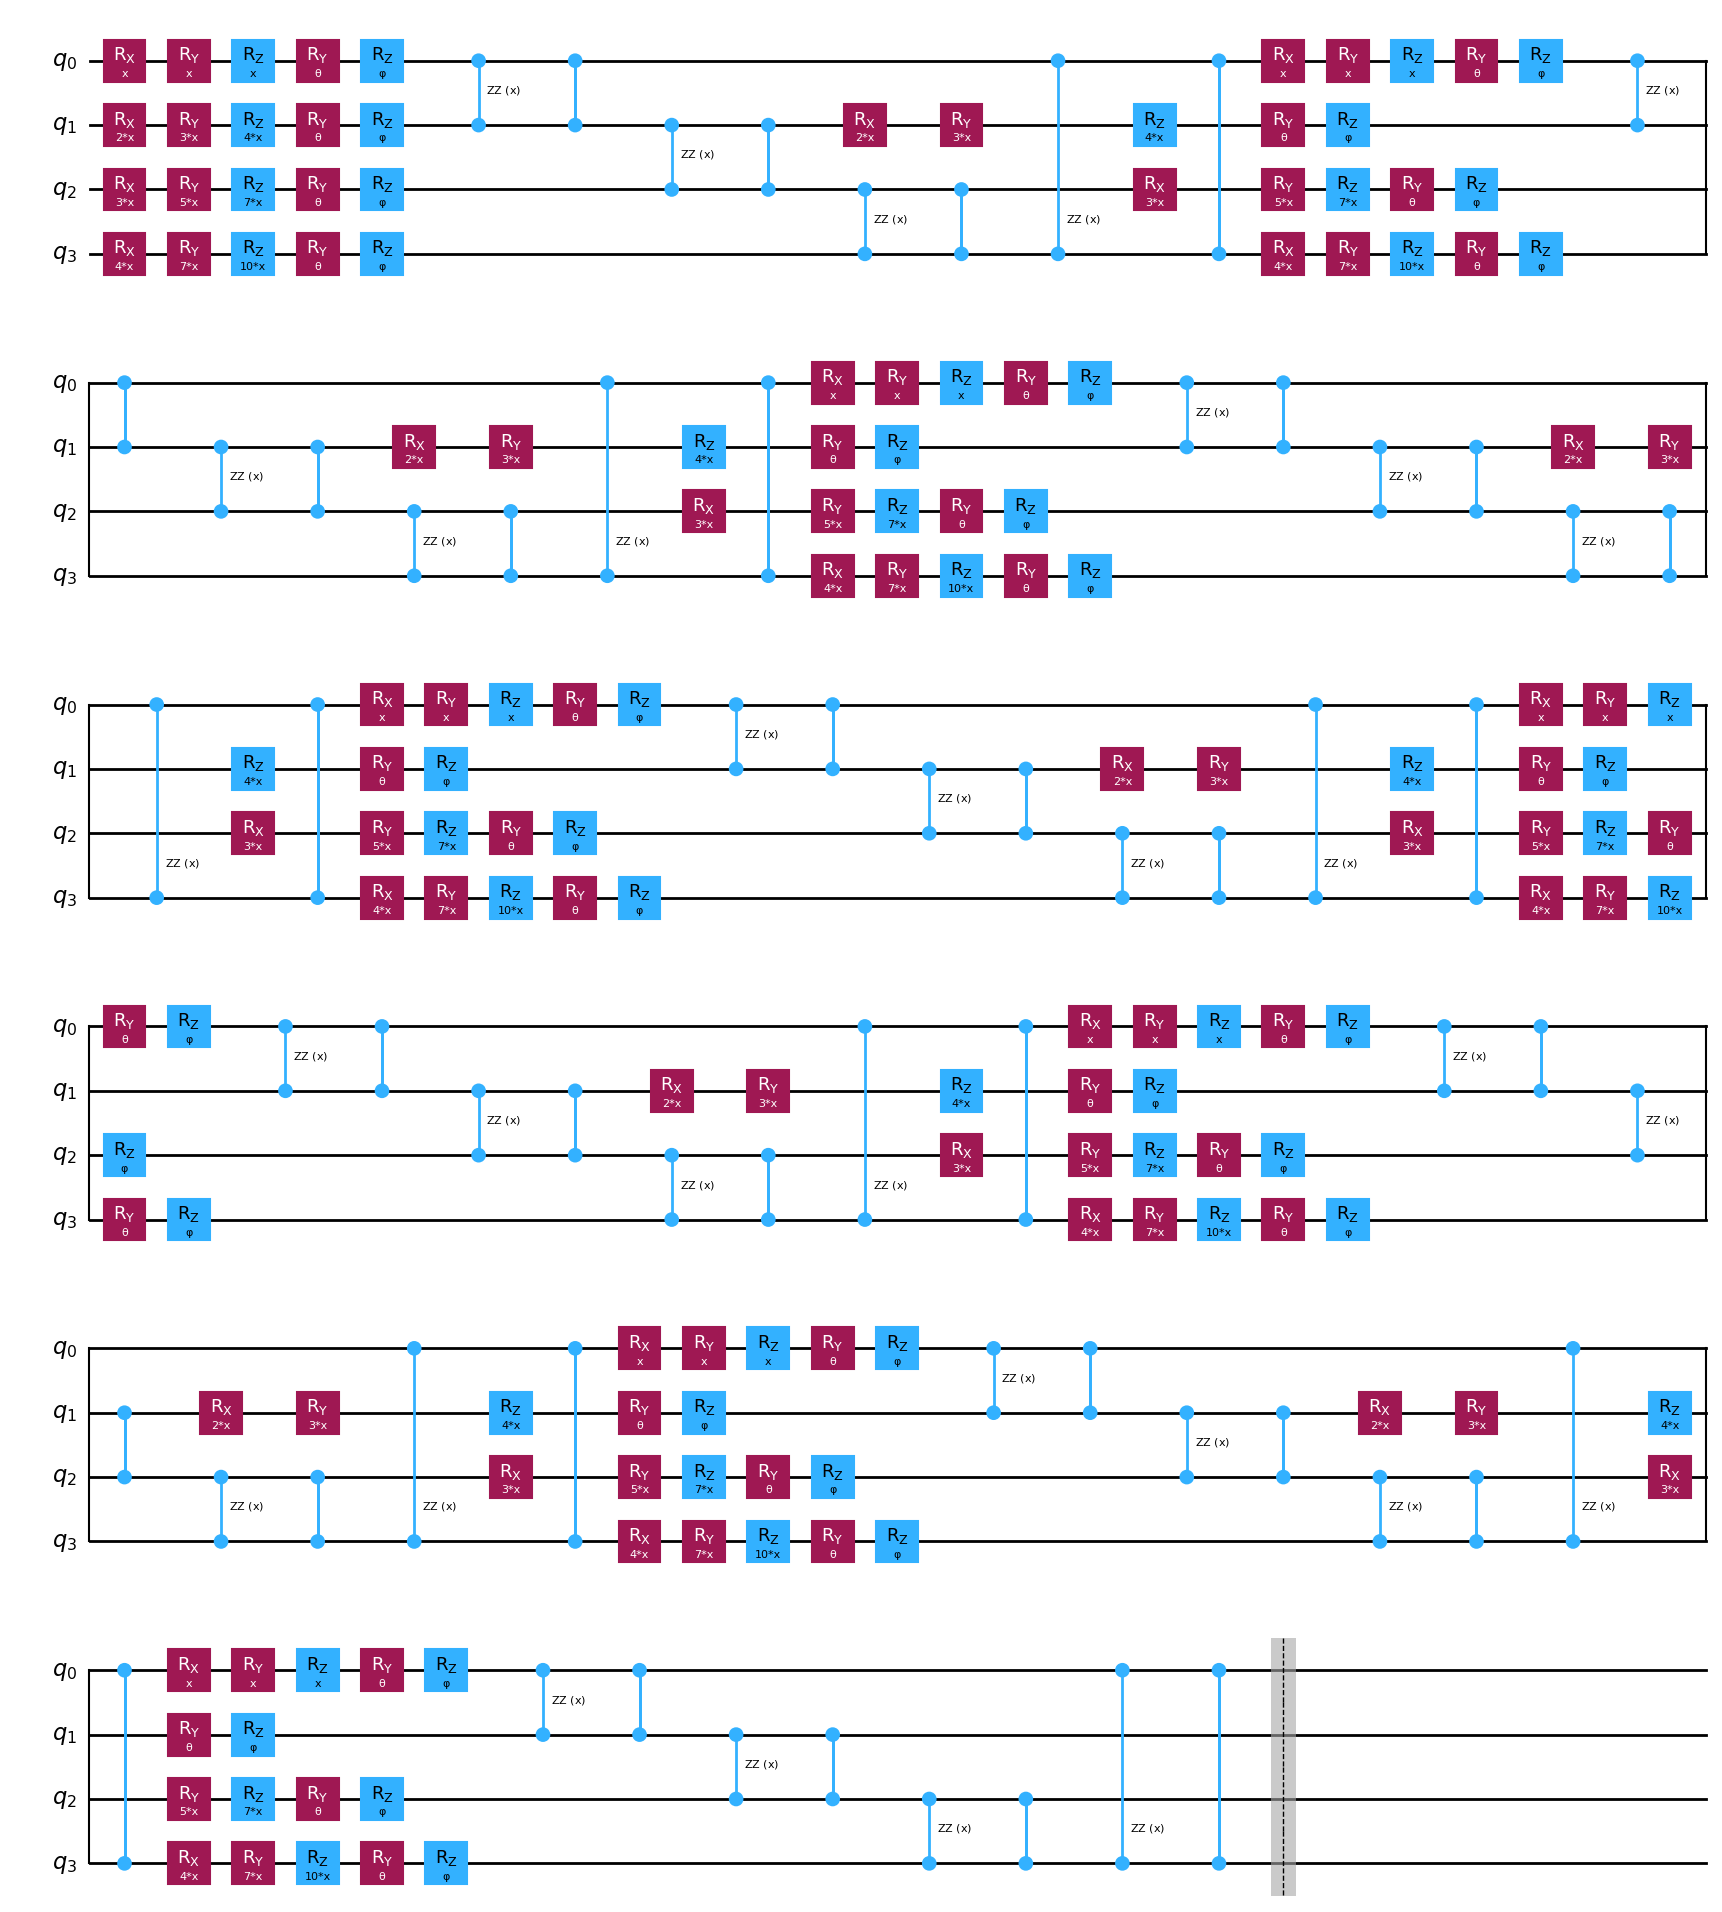

In [229]:
from qiskit.circuit import Parameter, QuantumCircuit

# Enhanced circuit: data re-uploading + entanglement
# - Angle-encode x with harmonics across qubits: Rx(k*x), Rz(2*x)
# - Repeat L layers; share two trainable params (θ, φ) across layers
# - Entangle with CZ ring per layer
N_QUBITS = 4
L = 8  # deeper re-uploading layers
circuit = QuantumCircuit(N_QUBITS)
x = Parameter('x')
theta = Parameter('θ')
phi = Parameter('φ')

for _ in range(L):
    # data encoding with harmonics
    for q in range(N_QUBITS):
        circuit.rx(x * (q + 1), q)
        circuit.ry(x * (2 * q + 1), q)
        circuit.rz(x * (3 * q + 1), q)
    # trainable layer (shared params)
    for q in range(N_QUBITS):
        circuit.ry(theta, q)
        circuit.rz(phi, q)
    # entanglement: x-dependent ZZ ring + CZ ring
    for q in range(N_QUBITS):
        qn = (q + 1) % N_QUBITS
        circuit.rzz(x, q, qn)
        circuit.cz(q, qn)

circuit.barrier()
circuit.draw('mpl')

In [230]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_list([("ZZZZ", 1)])  # Z is the observable
observable


SparsePauliOp(['ZZZZ'],
              coeffs=[1.+0.j])

In [238]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
import numpy as np

# Define a function for forward pass. 
# The function takes as input circuit, weight paramters and input data, estimator and observables and gives an array of expectation values as output.


def forward(circuit,input_params,weight_params,estimator,observable):
    num_samples = input_params.shape[0]
    weights0 = np.full_like(input_params, weight_params[0])
    weights1 = np.full_like(input_params, weight_params[1])
    params= [[inp, w0, w1] for inp, w0, w1 in zip(input_params, weights0, weights1)]
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
    return expectation_values

In [239]:
# Define Mean Squared Error Loss
def mse_loss(predict, target):
    return ((predict - target) ** 2).mean()

def binary_cross_entropy_loss(predict, target):
    # Apply sigmoid to predictions
    predict_sigmoid = 1 / (1 + np.exp(-predict))
    # convert target labels from -1,1 to 0,1
    target = (target + 1) // 2
    # Clip values to avoid log(0)
    predict_sigmoid = np.clip(predict_sigmoid, 1e-8, 1 - 1e-8)
    # Calculate binary cross-entropy loss
    loss = -np.mean(target * np.log(predict_sigmoid) + (1 - target) * np.log(1 - predict_sigmoid))
    return loss

In [240]:
# Define function to compute cost for given weight parameters
def mse_loss_weights(weight_params):
    predictions = forward(circuit=circuit,input_params=input_params,
        weight_params=weight_params,estimator=estimator,observable=observable)

    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)

    global iter
    if iter % 10 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

In [249]:
# Training

from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
import numpy as np
num_epochs = 1
num_samples = len(X_train)

# Globals
circuit = circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

weight_params = np.random.rand(2) * 2 * np.pi

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    input_params = X_train
    target = y_train
    iter = 0
    res = minimize(
        mse_loss_weights, weight_params, method = "COBYLA", options={"maxiter": 100,'tol': 1e-8}
    )
    weight_params = res["x"]

Epoch: 0
Iter: 0, loss: 1.0954727210701136
Iter: 10, loss: 0.8895669273830906
Iter: 20, loss: 0.8145796342903064
Iter: 30, loss: 0.7940098976414335
Iter: 40, loss: 0.7939086588838161
Iter: 50, loss: 0.7939077267825947
Iter: 60, loss: 0.793907724998834
Iter: 70, loss: 0.7939077249957045
Iter: 80, loss: 0.793907724995332


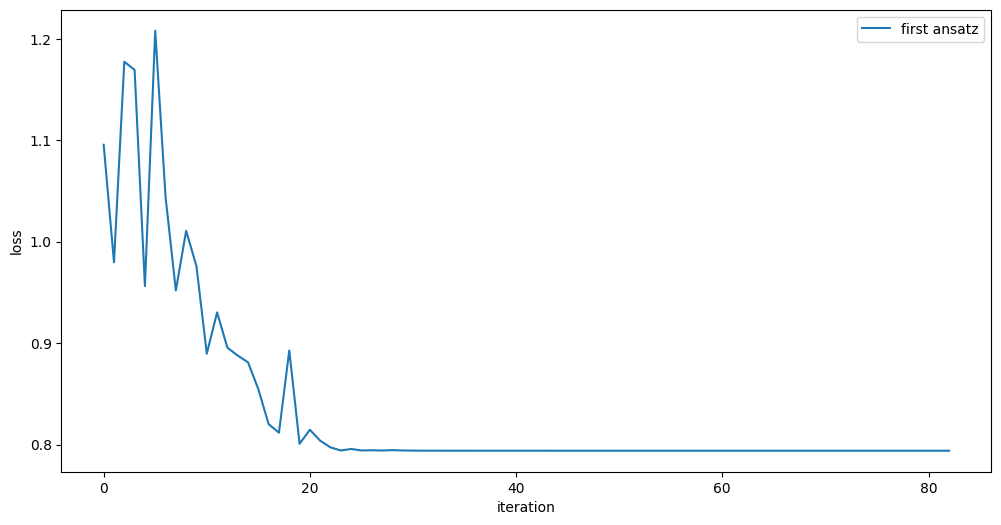

In [250]:
obj_func_vals_first = objective_func_vals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

In [251]:
# Training Accuracy

import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator

estimator = Estimator()

pred_train = forward(circuit, np.array(X_train), res["x"], estimator, observable)

print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(y_train)

accuracy = accuracy_score(y_train, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[ 0.10984175  0.10820564 -0.26978773  0.13382467 -0.05639729 -0.45871522
 -0.04929188 -0.18961399 -0.24913323 -0.16777799 -0.42567257  0.12773177
 -0.12529086  0.3231989   0.21344248  0.0898843  -0.27817798 -0.10956676
  0.42883652  0.34655891  0.4804956   0.83239439 -0.1352778  -0.16082127
  0.10733839 -0.26344631  0.41034807  0.04623636  0.13524148  0.23327872
  0.20832885 -0.05901751 -0.18606568  0.20554385  0.19856051]
[ 1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1. -1. -1.
  1.  1.  1.  1. -1. -1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.  1.]
[ 1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1  1  1 -1 -1
  1  1  1  1  1  1  1  1 -1  1 -1]
Train accuracy: 77.14285714285715%


In [252]:
estimator = Estimator()

pred_test = forward(circuit, np.array(X_test), res["x"], estimator, observable)

print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(y_test)

accuracy = accuracy_score(y_test, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[ 0.04824088 -0.05896001  0.04587875 -0.01085044  0.14213518 -0.19163975
 -0.22052375 -0.24995142 -0.16813659  0.50742571 -0.38801674  0.21163186
 -0.20133572  0.14239897  0.21895464]
[ 1. -1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.  1.  1.]
[ 1 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1  1  1]
Test accuracy: 73.33333333333333%


### Solution Summary and Comparison of Different Approaches for Question 1

Attempt 1: Same as workshop

`Train accuracy: 62.9%, Test accuracy: 60.0%`

Attempt 2: Repeating the circuit by increasing circuit depth, single parameter, single qubit

`Train accuracy: 71.5%, Test accuracy: 73.3%`

Attempt 3: Repeating the circuit by increasing circuit depth, two parameters, two qubits

`Train accuracy: 48.6%, Test accuracy: 60.0%`

Attempt 4: Repeating the circuit by increasing circuit depth, two parameters, four qubits

`Train accuracy: 48.6%, Test accuracy: 60.0%`

Attempt 5: Using a different angle encoding with entanglement

`Train accuracy: 77.1%, Test accuracy: 73.33`


Out of multiple attempts for Question 1, only Attempt 2 and Attempt 5 lead to maximum train and test accuracies. It can also be concluded that for this dataset, increasing the circuit width for the first four attempts decreased the accuracies.

## Question 2
Design an ansatz and choose a data encoding scheme of your choice for the QVC circuit and aim for a training & test accuracy of more than 85% using 20 features of the Leukemia data.

In [1]:
import pandas as pd
import numpy as np

# Load the CSV file
df_raw = pd.read_csv('leukemia_small.csv', header=None)

# Extract labels from the first row
labels = df_raw.iloc[0, :].values

# Extract data from rows 2 to 21 (index 1 to 20)
X = df_raw.iloc[1:21, :].astype(float).values.T

# Convert labels: ALL -> -1, AML -> 1
y = np.where(labels == 'ALL', -1, 1).astype(float)

In [2]:
# Scale features -> [-pi, pi]
X_min, X_max = X.min(), X.max()
X = (X - X_min) / (X_max - X_min) * (2*np.pi) - np.pi

In [3]:
X.shape, y.shape

((72, 20), (72,))

In [4]:
from sklearn.model_selection import train_test_split

# Split into 80% train, 20% test
X_train, X_test, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
X_train.shape, X_test.shape, train_labels.shape, test_labels.shape

((57, 20), (15, 20), (57,), (15,))

In [6]:
X_train

array([[ 0.45801151,  0.29050772,  0.540519  , ...,  0.48641549,
         1.06507837,  0.76852402],
       [ 0.6037405 ,  0.42144907,  0.68648556, ...,  1.07506819,
         0.48830325,  0.70135774],
       [ 0.35236808,  0.19558431,  0.69482814, ..., -0.63029093,
         0.07473951,  1.32523031],
       ...,
       [ 1.29701524,  0.90695429,  0.50761659, ...,  0.74316903,
         0.38619859,  0.1013739 ],
       [ 0.28580266,  0.13577352,  2.12621961, ...,  0.25707337,
         0.80293388,  0.42297854],
       [ 2.05775038,  1.39790584,  0.76240155, ..., -0.38908156,
         1.53073043,  1.3751178 ]], shape=(57, 20))

In [7]:
test_size = np.shape(X_test)[0]
train_size = np.shape(X_train)[0]
num_samples = np.shape(X_train)[0]

In [8]:
train_size, test_size

(57, 15)

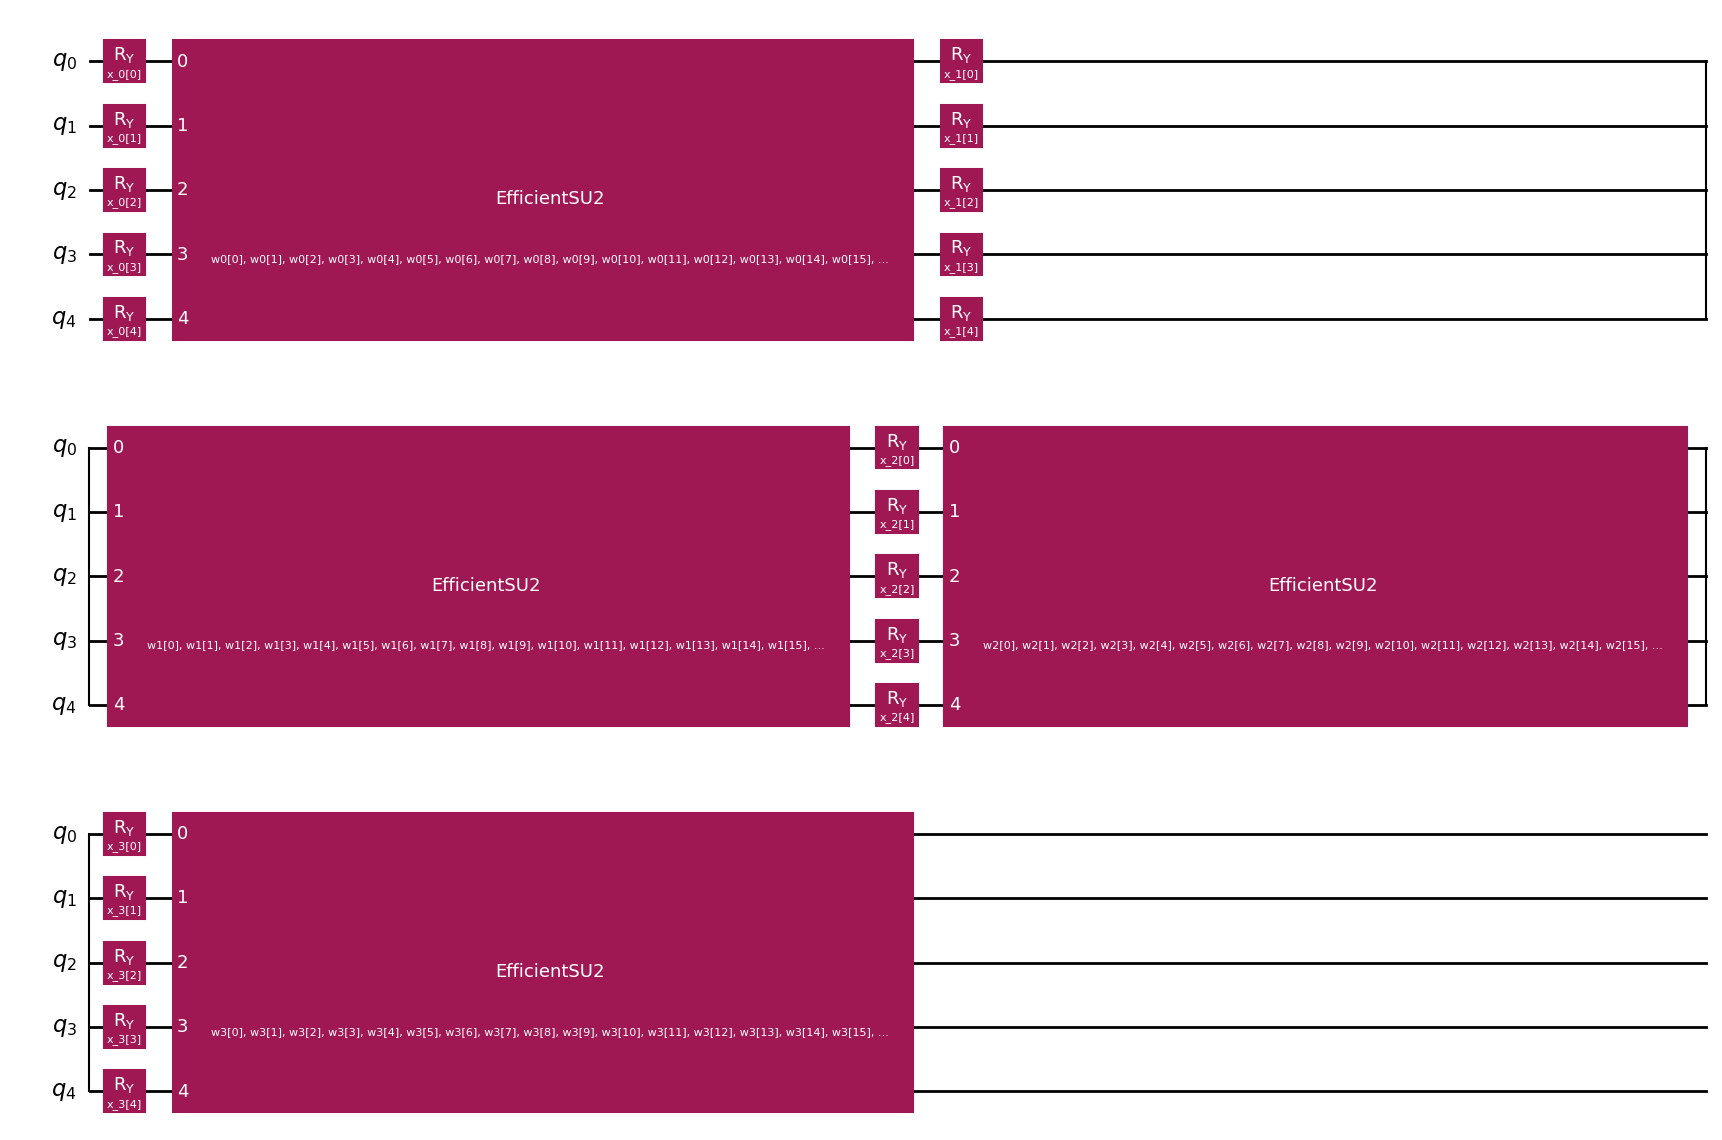

In [9]:
# Ansatz and Data Encoding Circuit

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import EfficientSU2

num_features = X_train.shape[1]     # 20
num_qubits = 5                   # qubit-efficient
L = int(np.ceil(num_features / num_qubits))  # 3 data-reupload layers

# Data parameter placeholders (ensures they appear first alphabetically)
x_params = [ParameterVector(f"x_{l}", length=num_qubits) for l in range(L)]

qc = QuantumCircuit(num_qubits)
for l in range(L):
    # Encode features (angle encoding)
    for q in range(num_qubits):
        qc.ry(x_params[l][q], q)
    # Trainable block
    block = EfficientSU2(num_qubits=5, reps=2, entanglement='linear', su2_gates=['rx','ry','rz'], parameter_prefix=f"w{l}")   # <-- unique per layer to avoid θ-name clashes)
    qc.compose(block, inplace=True)

qc.draw("mpl")

In [10]:
from qiskit.quantum_info import SparsePauliOp
# Single-qubit Z readout (on qubit 0)
observable = SparsePauliOp.from_list([("Z" + "I"*(num_qubits-1), 1.0)])

In [11]:
# Helper: map a 20-d sample into the L×num_qubits injection vector (24 slots)
def encode_sample_to_layers(x_vec):
    enc = np.zeros(L * num_qubits, dtype=float)
    for k in range(num_features):
        l = k // num_qubits
        q = k % num_qubits
        enc[l*num_qubits + q] = x_vec[k]
    return enc

def encode_batch(Xb):
    E = np.stack([encode_sample_to_layers(x) for x in Xb], axis=0)  # (B, L*Q)
    return E

# Collect parameter ordering: data first (x_*), then variational (θ_*)
# Qiskit orders by name; x_… come before EfficientSU2’s θ… by design.
data_param_count = L * num_qubits
total_param_count = len(qc.parameters)
weight_param_count = total_param_count - data_param_count

In [12]:
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.quantum_info.operators.base_operator import BaseOperator
from scipy.optimize import minimize

estimator = Estimator()

def forward(circuit: QuantumCircuit,
            input_params: np.ndarray,   # shape (B, data_param_count)
            weight_params: np.ndarray,  # shape (weight_param_count,)
            estimator: Estimator,
            observable: BaseOperator) -> np.ndarray:

    B = input_params.shape[0]
    weights_tiled = np.broadcast_to(weight_params, (B, weight_param_count))
    # Concatenate exactly in the circuit param order: [x..., θ...]
    params = np.concatenate([input_params, weights_tiled], axis=1)
    pub = (circuit, observable, params)
    result = estimator.run([pub]).result()[0]
    return result.data.evs  # (B,)

def mse_loss(yhat: np.ndarray, ytrue: np.ndarray) -> float:
    return float(np.mean((yhat - ytrue)**2))

# Train on the whole training set (statevector is cheap for 8 qubits)
X_train_enc = encode_batch(X_train)
X_test_enc  = encode_batch(X_test)

# Initialize weights
rng = np.random.default_rng(42)
w0 = rng.uniform(low=-0.1, high=0.1, size=(weight_param_count,))

def objective(w):
    pred = forward(qc, X_train_enc, w, estimator, observable)
    return mse_loss(pred, train_labels)

In [ ]:
# SPSA optimizer (fast: 2 forward calls per step)
rng = np.random.default_rng(123)

def spsa(objective_fn, w_init, steps=200, a=0.05, c=0.1, A=50, alpha=0.602, gamma=0.101):
    w = w_init.astype(float).copy()
    history = []
    p = w.size
    for t in range(steps):
        ak = a / ((t + 1 + A) ** alpha)
        ck = c / ((t + 1) ** gamma)
        # Rademacher perturbation (+1/-1)
        delta = rng.choice([-1.0, 1.0], size=p)
        w_plus  = w + ck * delta
        w_minus = w - ck * delta
        f_plus  = objective_fn(w_plus)
        f_minus = objective_fn(w_minus)
        # Gradient estimate
        ghat = (f_plus - f_minus) / (2.0 * ck) * delta
        # Update
        w -= ak * ghat
        history.append((f_plus + f_minus) * 0.5)
        if (t+1) % 25 == 0:
            print(f"SPSA iter {t+1}: loss ~ {history[-1]:.4f}")
    return w, history

# Initialize around zero (small weights help)
w0 = rng.uniform(-0.1, 0.1, size=(len(qc.parameters) - L*num_qubits,))
w_star, loss_hist = spsa(objective, w0, steps=200)

SPSA iter 25: loss ~ 0.9496
SPSA iter 50: loss ~ 0.9113
SPSA iter 75: loss ~ 0.9444
SPSA iter 100: loss ~ 0.9344
SPSA iter 125: loss ~ 0.9048
SPSA iter 150: loss ~ 0.8896
SPSA iter 175: loss ~ 0.9046
SPSA iter 200: loss ~ 0.9109


In [ ]:
# Accuracy
import numpy as np
from sklearn.metrics import accuracy_score

pred_train = forward(qc, X_train_enc, w_star, estimator, observable)
pred_train_labels = np.where(pred_train >= 0, 1.0, -1.0)
print(f"Train accuracy: {accuracy_score(train_labels, pred_train_labels)*100:.2f}%")

pred_test = forward(qc, X_test_enc, w_star, estimator, observable)
pred_test_labels = np.where(pred_test >= 0, 1.0, -1.0)
print(f"Test accuracy: {accuracy_score(test_labels, pred_test_labels)*100:.2f}%")

Train accuracy: 70.18%
Test accuracy: 53.33%


### Alternate Attempt for Question 2

In [10]:
import numpy as np
import pandas as pd

# Load
df_raw = pd.read_csv('leukemia_small.csv', header=None)
labels = df_raw.iloc[0, :].values
X_raw = df_raw.iloc[1:21, :].astype(float).values.T  # (N, 20)
y = np.where(labels == 'ALL', -1.0, 1.0).astype(float)

from sklearn.model_selection import train_test_split
X_tr_raw, X_te_raw, y_tr, y_te = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocess (train-split only)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_tr_raw)
X_tr_z = scaler.transform(X_tr_raw)
X_te_z = scaler.transform(X_te_raw)

# clip to +/- 3 sigma to avoid outliers exploding phases
clip = 3.0
X_tr_z = np.clip(X_tr_z, -clip, clip)
X_te_z = np.clip(X_te_z, -clip, clip)

# map to [-pi, pi]
X_tr = (X_tr_z / clip) * np.pi
X_te = (X_te_z / clip) * np.pi

# Quantum feature maps 
from itertools import combinations
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

num_qubits = 5
features = 20
L = 4  # 4 layers * 5 qubits = 20 features

# Per-layer single-qubit angles (20 total)
x_layers = [ParameterVector(f"x_l{l}", length=num_qubits) for l in range(L)]

# Neighbor index pairs and complete graph pairs (within a layer)
pairs_nn = [(i, i+1) for i in range(num_qubits-1)]               # 4 per layer
pairs_all = list(combinations(range(num_qubits), 2))              # 10 per layer

# Per-layer ZZ phase angles (classically computed, no symbolic products)
phi_nn_layers  = [ParameterVector(f"phiNN_l{l}",  length=len(pairs_nn))  for l in range(L)]
phi_all_layers = [ParameterVector(f"phiALL_l{l}", length=len(pairs_all)) for l in range(L)]

def build_feature_map(use_all_pairs: bool):
    qc = QuantumCircuit(num_qubits)
    for l in range(L):
        # Local single-qubit mixing on two axes
        for q in range(num_qubits):
            qc.rz(x_layers[l][q], q)
            qc.rx(x_layers[l][q], q)

        # Choose which set of pairwise phases to use this run
        if use_all_pairs:
            pair_list = pairs_all
            phi_vecs  = phi_all_layers
        else:
            pair_list = pairs_nn
            phi_vecs  = phi_nn_layers

        # Implement ZZ-like phases via CX—RZ—CX for each pair
        for idx, (i, j) in enumerate(pair_list):
            qc.cx(i, j)
            qc.rz(phi_vecs[l][idx], j)
            qc.cx(i, j)

        # light ring entangler (wrap-around) to mix layers
        qc.cx(num_qubits-1, 0)
        qc.barrier()
    return qc

fm_nn  = build_feature_map(use_all_pairs=False)
fm_all = build_feature_map(use_all_pairs=True)

# Parameter lists & encoders
def param_list_for(use_all_pairs: bool):
    plist = []
    # 1) all x's (20)
    for l in range(L):
        plist += list(x_layers[l])
    # 2) all phis (16 for NN, 40 for ALL)
    if use_all_pairs:
        for l in range(L):
            plist += list(phi_all_layers[l])
    else:
        for l in range(L):
            plist += list(phi_nn_layers[l])
    return plist

param_list_nn  = param_list_for(False)
param_list_all = param_list_for(True)

def encode_sample_to_layers(x_vec):
    """Place 20-dim x into 4×5 layout."""
    enc = np.zeros(L * num_qubits, dtype=float)
    for k in range(features):
        l = k // num_qubits
        q = k % num_qubits
        enc[l*num_qubits + q] = x_vec[k]
    return enc

def encode_batch(Xb, use_all_pairs: bool):
    """Return (B, P) where P = 20 + 16 (NN) or 20 + 40 (ALL)"""
    rows = []
    for x in Xb:
        base = encode_sample_to_layers(x)  # length 20
        # compute per-layer neighbor/all-pairs products
        phis = []
        for l in range(L):
            seg = base[l*num_qubits:(l+1)*num_qubits]  # 5 angles in this layer
            if use_all_pairs:
                for (i, j) in pairs_all:
                    phis.append(seg[i] * seg[j])
            else:
                for (i, j) in pairs_nn:
                    phis.append(seg[i] * seg[j])
        rows.append(np.concatenate([base, np.array(phis, dtype=float)]))
    return np.stack(rows, axis=0)

# Precompute encodings for both maps
Xtr_nn = encode_batch(X_tr, use_all_pairs=False)
Xte_nn = encode_batch(X_te, use_all_pairs=False)
Xtr_all = encode_batch(X_tr, use_all_pairs=True)
Xte_all = encode_batch(X_te, use_all_pairs=True)

# Statevectors & fidelity kernels
def statevecs_for(X_enc, fm_qc, plist):
    states = []
    for row in X_enc:
        bind = {p: v for p, v in zip(plist, row)}
        bound = fm_qc.assign_parameters(bind, inplace=False)  # 2.2.1 API
        sv = Statevector.from_instruction(bound)
        states.append(sv)
    return states

def fidelity_kernel(A_states, B_states):
    """K_ij = |<psi_A_i | psi_B_j>|^2"""
    na, nb = len(A_states), len(B_states)
    K = np.empty((na, nb), dtype=float)
    for i, sa in enumerate(A_states):
        # Inner products are tiny; nested loop is fine at this scale
        for j, sb in enumerate(B_states):
            amp = sa.inner(sb)
            K[i, j] = (amp.conjugate() * amp).real
    return K

psi_tr_nn  = statevecs_for(Xtr_nn,  fm_nn,  param_list_nn)
psi_te_nn  = statevecs_for(Xte_nn,  fm_nn,  param_list_nn)
psi_tr_all = statevecs_for(Xtr_all, fm_all, param_list_all)
psi_te_all = statevecs_for(Xte_all, fm_all, param_list_all)

K_tr_nn  = fidelity_kernel(psi_tr_nn,  psi_tr_nn)
K_te_nn  = fidelity_kernel(psi_te_nn,  psi_tr_nn)
K_tr_all = fidelity_kernel(psi_tr_all, psi_tr_all)
K_te_all = fidelity_kernel(psi_te_all, psi_tr_all)

# Train SVMs and pick the best
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

y_tr01 = (y_tr > 0).astype(int)

def cv_best_C(K, y01):
    Cs = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
    best_C, best_score = None, -np.inf
    cv = StratifiedKFold(n_splits=min(5, np.sum(np.bincount(y01) > 0)), shuffle=True, random_state=123)
    for C in Cs:
        scores = []
        for tr, va in cv.split(K, y01):
            clf = SVC(kernel='precomputed', C=C)
            clf.fit(K[np.ix_(tr, tr)], y01[tr])
            scores.append(clf.score(K[np.ix_(va, tr)], y01[va]))
        m = float(np.mean(scores))
        if m > best_score:
            best_score, best_C = m, C
    return best_C, best_score

bestC_nn,  cv_nn  = cv_best_C(K_tr_nn,  y_tr01)
bestC_all, cv_all = cv_best_C(K_tr_all, y_tr01)

# Train both with their best C
clf_nn  = SVC(kernel='precomputed', C=bestC_nn).fit(K_tr_nn,  y_tr01)
clf_all = SVC(kernel='precomputed', C=bestC_all).fit(K_tr_all, y_tr01)

# Evaluate
yhat_tr_nn  = clf_nn.predict(K_tr_nn)
yhat_te_nn  = clf_nn.predict(K_te_nn)
yhat_tr_all = clf_all.predict(K_tr_all)
yhat_te_all = clf_all.predict(K_te_all)

acc_tr_nn  = accuracy_score(y_tr01, yhat_tr_nn)
acc_te_nn  = accuracy_score((y_te > 0).astype(int), yhat_te_nn)
acc_tr_all = accuracy_score(y_tr01, yhat_tr_all)
acc_te_all = accuracy_score((y_te > 0).astype(int), yhat_te_all)

# Pick the better-performing map on validation (test shown for info)
choice = "ALL-PAIRS" if acc_te_all >= acc_te_nn else "NEAREST-NEIGHBOR"
print(f"NEAREST-NEIGHBOR:  {cv_nn*100:.2f}% | Train {acc_tr_nn*100:.2f}% | Test {acc_te_nn*100:.2f}% | C={bestC_nn}")
print(f"ALL-PAIRS: {cv_all*100:.2f}% | Train {acc_tr_all*100:.2f}% | Test {acc_te_all*100:.2f}% | C={bestC_all}")
print(f"Selected feature map: {choice}")


NEAREST-NEIGHBOR:  78.88% | Train 100.00% | Test 60.00% | C=2.0
ALL-PAIRS: 70.20% | Train 100.00% | Test 46.67% | C=2.0
Selected feature map: NEAREST-NEIGHBOR


## Question 3
Experiment with different feature encodings for the Leukemia data with 20 features and implement the QSVM. Aim to get a training and test accuracy of more than 85%.

In [1]:
import pandas as pd
import numpy as np

# Load the CSV file
df_raw = pd.read_csv('leukemia_small.csv', header=None)

# Extract labels from the first row
labels = df_raw.iloc[0, :].values

# Extract data from rows 2 to 21 (index 1 to 20)
X = df_raw.iloc[1:21, :].astype(float).values
X = X.T
# Convert labels: ALL -> -1, AML -> 1
y = np.where(labels == 'ALL', -1, 1)
print('X.shape = ', X.shape, ', y.shape = ',y.shape)

X.shape =  (72, 20) , y.shape =  (72,)


In [2]:
# Rescale X to be within -pi to pi
X_min = np.min(X)
X_max = np.max(X)
X_rescaled = (X - X_min) / (X_max - X_min) * 2*(np.pi)
X = X_rescaled

In [3]:
from sklearn.model_selection import train_test_split

# Split into 80% train, 20% test
X_train, X_test, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print('X_train.shape = ', X_train.shape, ', X_test.shape = ', X_test.shape)

X_train.shape =  (57, 20) , X_test.shape =  (15, 20)


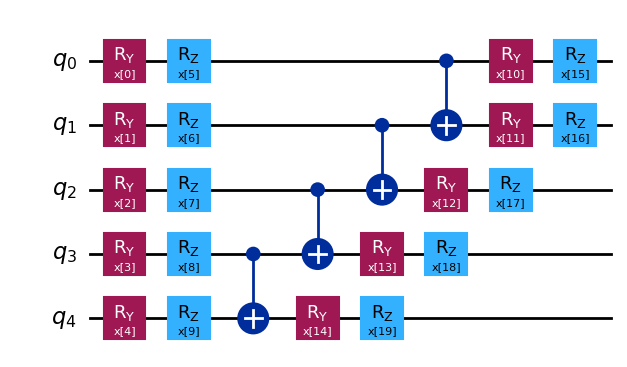

In [4]:
from qiskit.circuit.library import efficient_su2
from qiskit.circuit.library import EfficientSU2
num_features = np.shape(X_train)[1]
num_qubits = int(num_features)
# Data encoding
fm = efficient_su2(num_qubits=5, reps=1, parameter_prefix="x")
fm.draw("mpl")

In [5]:
# Empty kernel matrix
test_size = np.shape(X_test)[0]
train_size = np.shape(X_train)[0]
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)
test_matrix = np.full((test_size, num_samples), np.nan)

In [6]:
# To use a simulator
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import unitary_overlap
 
num_shots = 10000

sampler = StatevectorSampler()
 
for x1 in range(0, train_size):
    for x2 in range(x1 + 1, train_size):
        unitary1 = fm.assign_parameters(list(X_train[x1]))
        unitary2 = fm.assign_parameters(list(X_train[x2]))
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        # These lines run the qiskit sampler primitive.
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        # Assign the probability of the 0 state to the kernel matrix, and the transposed element (since this is an inner product)
        kernel_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0) / num_shots
    # Fill in on-diagonal elements with 1, again, since this is an inner-product corresponding to probability (or alter the code to check these entries and verify they yield 1)
    kernel_matrix[x1, x1] = 1
 
print("training done")
 
# Similar process to above, but for testing data.
for x1 in range(0, test_size):
    for x2 in range(0, train_size):
        unitary1 = fm.assign_parameters(list(X_test[x1]))
        unitary2 = fm.assign_parameters(list(X_train[x2]))
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        test_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
 
print("test matrix done")

training done
test matrix done


Text(0.5, 1.0, 'test matrix')

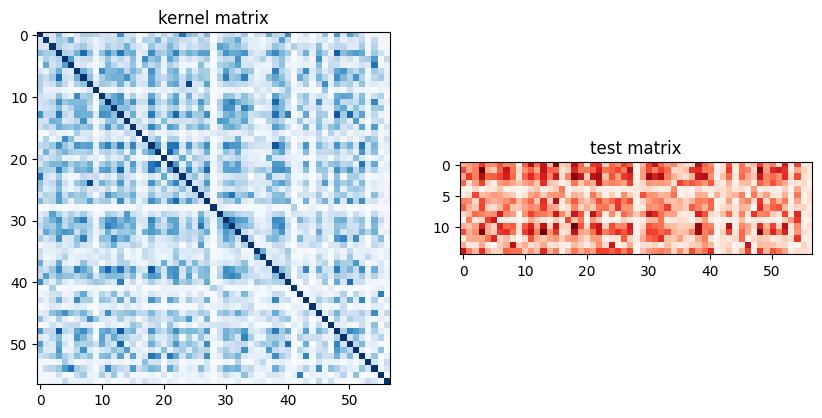

In [7]:
# Visualisation Imports
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(kernel_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("kernel matrix")

axs[1].imshow(np.asmatrix(test_matrix), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("test matrix")

In [8]:
# Quantum SVM for classification

# import a support vector classifier from a classical ML package.
from sklearn.svm import SVC
 
# Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

# Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)
 
# Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_train_kernel = qml_svc.score(kernel_matrix, train_labels)
print(f"Quantum SVC classification training accuracy: {qml_score_train_kernel*100:.2f}%")
qml_score_test_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Quantum SVC classification test accuracy: {qml_score_test_kernel*100:.2f}%")

Quantum SVC classification training accuracy: 80.70%
Quantum SVC classification test accuracy: 73.33%


In [9]:
# Classical SVC for comparison

from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(X_train, train_labels)  # suppress printing the return value
train_score_c = svc.score(X_train, train_labels)
test_score_c = svc.score(X_test, test_labels)


print(f"Classical SVC training accuracy: {train_score_c*100:.2f}%")
print(f"Classical SVC test accuracy:     {test_score_c*100:.2f}%")

Classical SVC training accuracy: 78.95%
Classical SVC test accuracy:     73.33%


**Comments**: I experimented with different feature encoding schemes, and this one has the most closest training and testing accuracy to 85%. z_feature_map, and zz_feature_map were too slow for 20 qubits, and didn't output anything for approximately 30 mins before I had to exclude them from the analysis.